In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Libs
import h5py
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print("Failed to enable GPU memory growth:", e)

In [ ]:
# Defining paths to the HDF5 files
train_xnet_path = '/content/drive/MyDrive/train_spatial_data.h5'
val_xnet_path = '/content/drive/MyDrive/val_spatial_data.h5'

# Loading train_data from the HDF5 file
train_xnet_data = []
with h5py.File(train_xnet_path, 'r') as f:
    frames = f['frames'][:]  # Shape: (num_frames, 224, 224, 3)
    labels = f['labels'][:]  # Shape: (num_frames,)
    for frame, label in zip(frames, labels):
        train_xnet_data.append((frame, label))

# Loading val_data from the HDF5 file
val_xnet_data = []
with h5py.File(val_xnet_path, 'r') as f:
    frames = f['frames'][:]  # Shape: (num_frames, 224, 224, 3)
    labels = f['labels'][:]  # Shape: (num_frames,)
    for frame, label in zip(frames, labels):
        val_xnet_data.append((frame, label))

# Checking the loaded data
print("Training Data:")
print(f"Total number of frames: {len(train_xnet_data)}")
print(f"Shape of first frame: {train_xnet_data[0][0].shape}")
print(f"First label: {train_xnet_data[0][1]}")

print("\nValidation Data:")
print(f"Total number of frames: {len(val_xnet_data)}")
print(f"Shape of first frame: {val_xnet_data[0][0].shape}")
print(f"First label: {val_xnet_data[0][1]}")

Training Data:
Total number of frames: 11065
Shape of first frame: (224, 224, 3)
First label: 0

Validation Data:
Total number of frames: 2767
Shape of first frame: (224, 224, 3)
First label: 0


In [ ]:
def dataset_generator(data):
    for frame, label in data:
        # Ensuring the frame has the correct shape (224, 224, 3)
        if frame.shape != (224, 224, 3):
            print(f"Warning: Frame shape is {frame.shape}. Reshaping to (224, 224, 3).")
            frame = tf.reshape(frame, (224, 224, 3))  # If not, Reshape to correct dimensions
        yield frame, label


In [ ]:
train_xnet_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_xnet_data),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  # Ensure correct shape
        tf.TensorSpec(shape=(), dtype=tf.float32)  # Scalar label
    )
)

val_xnet_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(val_xnet_data),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  # Ensure correct shape
        tf.TensorSpec(shape=(), dtype=tf.float32)  # Scalar label
    )
)

In [ ]:
def check_frame_shapes(dataset, dataset_name):
    """
    Check if all frames in the dataset have the expected shape (224, 224, 3).
    If any frame has an inconsistent shape, raise an error or print a warning.

    Args:
        dataset: The dataset to check (e.g., train_xnet_dataset or val_xnet_dataset).
        dataset_name: The name of the dataset (for logging purposes).
    """
    print(f"Checking frame shapes in {dataset_name}...")
    for i, (frame, label) in enumerate(dataset):
        if frame.shape != (224, 224, 3):
            print(f"Error: Frame {i} in {dataset_name} has shape {frame.shape}. Expected (224, 224, 3).")
            return  # Stop checking and exit the function
    print(f"All frames in {dataset_name} have the correct shape (224, 224, 3).")

# Check shapes in the training dataset
check_frame_shapes(train_xnet_dataset, "train_xnet_dataset")

# Check shapes in the validation dataset
check_frame_shapes(val_xnet_dataset, "val_xnet_dataset")

Checking frame shapes in train_xnet_dataset...
All frames in train_xnet_dataset have the correct shape (224, 224, 3).
Checking frame shapes in val_xnet_dataset...
All frames in val_xnet_dataset have the correct shape (224, 224, 3).


In [ ]:
# Checking shapes of the first few frames and labels in the training dataset
for frames, labels in train_xnet_dataset.take(1):
    print("Training Data:")
    print("Frames shape:", frames.shape)  # (224, 224, 3)
    print("Label shape:", labels.shape)  # () (scalar)
    print("Label value:", labels.numpy())  # label value
    break

# Checking shapes of the first few frames and labels in the validation dataset
for frames, labels in val_xnet_dataset.take(1):
    print("\nValidation Data:")
    print("Frames shape:", frames.shape)  # (224, 224, 3)
    print("Label shape:", labels.shape)  # () (scalar)
    print("Label value:", labels.numpy())  # label value
    break

Training Data:
Frames shape: (224, 224, 3)
Label shape: ()
Label value: 0.0

Validation Data:
Frames shape: (224, 224, 3)
Label shape: ()
Label value: 0.0


Visualizing First Sample from Training Data:
Frame shape: (224, 224, 3)
Label value: 0.0
Frame min value: 0.039215688
Frame max value: 0.8039216


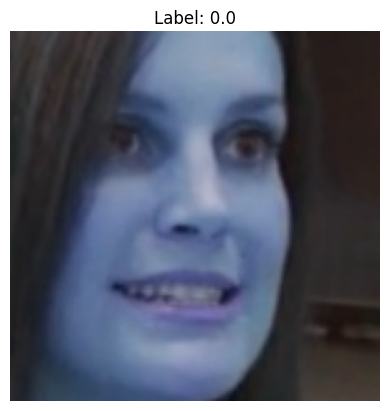


Visualizing First Sample from Validation Data:
Frame shape: (224, 224, 3)
Label value: 0.0
Frame min value: 0.0
Frame max value: 0.99607843


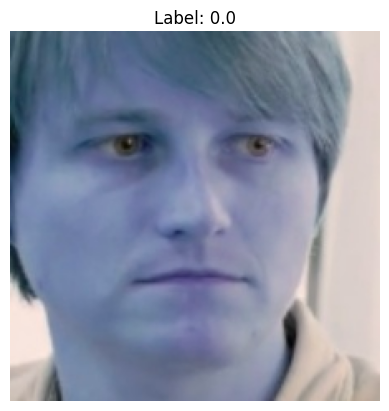

In [ ]:
def visualize_first_sample(dataset):
    """
    Visualizes the first sample (frame and label) from the dataset.

    Args:
        dataset: The dataset (e.g., train_xnet_dataset or val_xnet_dataset).
    """
    for frame, label in dataset.take(1):
        print("Frame shape:", frame.shape)  # Debug
        print("Label value:", label.numpy())  # Debug
        print("Frame min value:", tf.reduce_min(frame).numpy())  # Debug
        print("Frame max value:", tf.reduce_max(frame).numpy())  # Debug

        # Ensure the frame has the correct shape (224, 224, 3)
        if frame.shape != (224, 224, 3):
            print(f"Warning: Frame shape is {frame.shape}. Reshaping to (224, 224, 3).")
            frame = tf.reshape(frame, (224, 224, 3))  # Reshape to correct dimensions

        # Displaying the frame
        plt.imshow(frame.numpy())  # Convert TensorFlow tensor to NumPy array for visualization
        plt.title(f"Label: {label.numpy()}")
        plt.axis('off')
        plt.show()
        break

# Visualizing the first sample from the training dataset
print("Visualizing First Sample from Training Data:")
visualize_first_sample(train_xnet_dataset)

# Visualizing the first sample from the validation dataset
print("\nVisualizing First Sample from Validation Data:")
visualize_first_sample(val_xnet_dataset)

In [ ]:
def check_min_max_frames(dataset, dataset_name):
    print(f"Checking min and max frame values for {dataset_name}...")
    min_value = float('inf')
    max_value = float('-inf')

    for frames, label in dataset:
        # Update global min and max
        batch_min = tf.reduce_min(frames).numpy()
        batch_max = tf.reduce_max(frames).numpy()
        min_value = min(min_value, batch_min)
        max_value = max(max_value, batch_max)

    print(f"Minimum frame value in {dataset_name}: {min_value}")
    print(f"Maximum frame value in {dataset_name}: {max_value}")
    print()

# Checking min and max values for train_dataset
check_min_max_frames(train_xnet_dataset, "train_xnet_dataset")

# Checking min and max values for val_dataset
check_min_max_frames(val_xnet_dataset, "val_xnet_dataset")

Checking min and max frame values for train_xnet_dataset...
Minimum frame value in train_xnet_dataset: 0.0
Maximum frame value in train_xnet_dataset: 1.0

Checking min and max frame values for val_xnet_dataset...
Minimum frame value in val_xnet_dataset: 0.0
Maximum frame value in val_xnet_dataset: 1.0



In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.1),      # Random rotation (±10%)
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation (±10%)
    tf.keras.layers.RandomZoom(height_factor=0.1),  # Random zoom (±10%)
    tf.keras.layers.GaussianNoise(stddev=0.01),  # Add slight Gaussian noise
    tf.keras.layers.RandomContrast(factor=0.1),  # Slight contrast adjustment (±10%)
])

In [ ]:
def augment_data(frames, label):
    """
    Applies data augmentation to the frames.
    Args:
        frames: Tensor of shape (224, 224, 3)  # Individual frame
        label: Tensor of shape ()  # Scalar label
    Returns:
        augmented_frames: Tensor of shape (224, 224, 3)
        label: Tensor of shape ()
    """
    # Ensure the shape of frames is fully defined
    frames = tf.ensure_shape(frames, [224, 224, 3])  # Shape: (224, 224, 3)

    # Debug
    #tf.print("Input frames min:", tf.reduce_min(frames))
    #tf.print("Input frames max:", tf.reduce_max(frames))

    # Apply augmentation to the frame
    augmented_frames = data_augmentation(tf.expand_dims(frames, axis=0))[0]

    # Debug
    #tf.print("Augmented frames min (before clipping):", tf.reduce_min(augmented_frames))
    #tf.print("Augmented frames max (before clipping):", tf.reduce_max(augmented_frames))

    # Clip pixel values to [0, 1] after augmentation
    augmented_frames = tf.clip_by_value(augmented_frames, 0.0, 1.0)

    # Debug
    #tf.print("Augmented frames min (after clipping):", tf.reduce_min(augmented_frames))
    #tf.print("Augmented frames max (after clipping):", tf.reduce_max(augmented_frames))

    return augmented_frames, label

# Applying augmentation to the training dataset
train_xnet_augmented_dataset = train_xnet_dataset.map(augment_data)

Visualizing First Augmented Sample from Training Data:
Augmented Frame shape: (224, 224, 3)
Label value: 0.0
Augmented Frame min value: 0.047347188
Augmented Frame max value: 0.81308264


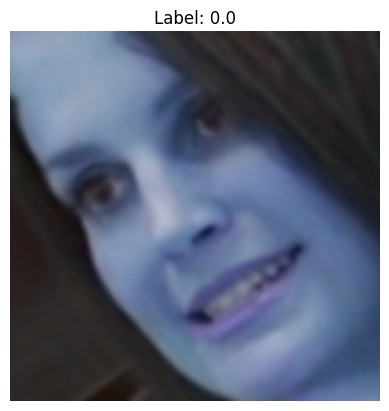

In [ ]:
def visualize_first_augmented_sample(dataset):
    """
    Visualizes the first augmented sample (frame and label) from the dataset.

    Args:
        dataset: The augmented dataset (e.g., train_xnet_augmented_dataset).
    """
    for frame, label in dataset.take(1):
        print("Augmented Frame shape:", frame.shape)  # Debug
        print("Label value:", label.numpy())  # Debug
        print("Augmented Frame min value:", tf.reduce_min(frame).numpy())  # Debug
        print("Augmented Frame max value:", tf.reduce_max(frame).numpy())  # Debug

        # Ensure the frame has the correct shape (224, 224, 3)
        if frame.shape != (224, 224, 3):
            print(f"Warning: Augmented Frame shape is {frame.shape}. Reshaping to (224, 224, 3).")
            frame = tf.reshape(frame, (224, 224, 3))  # Reshape to correct dimensions

        # Display the augmented frame
        plt.imshow(frame.numpy())  # Convert TensorFlow tensor to NumPy array for visualization
        plt.title(f"Label: {label.numpy()}")  # Use the scalar label
        plt.axis('off')
        plt.show()
        break

# Visualizing the first sample from the augmented training dataset
print("Visualizing First Augmented Sample from Training Data:")
visualize_first_augmented_sample(train_xnet_augmented_dataset)

**Spatial Modeling**

In [ ]:
def flatten_dataset(dataset):
    """
    Flatten the dataset to treat each frame as an independent sample.
    Args:
        dataset: A TensorFlow dataset with shape (224, 224, 3) for frames and () for labels.
    Returns:
        A flattened dataset with shape (224, 224, 3) for frames and () for labels.
    """
    return dataset.flat_map(lambda frame, label: tf.data.Dataset.from_tensors((frame, label)))

In [ ]:
# Apply flattening to the training and validation datasets
train_xnet_flattened = flatten_dataset(train_xnet_augmented_dataset)
val_xnet_flattened = flatten_dataset(val_xnet_dataset)

In [ ]:
# Batch the flattened datasets
batch_size = 16
train_xnet_loader = train_xnet_flattened.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_xnet_loader = val_xnet_flattened.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Debugging: Check the shapes of the flattened and batched datasets
for frames, labels in train_xnet_loader.take(1):
    print("Frames shape (train_xnet_loader):", frames.shape)  # (batch_size, 224, 224, 3)
    print("Labels shape (train_xnet_loader):", labels.shape)  # (batch_size,)
    break

for frames, labels in val_xnet_loader.take(1):
    print("Frames shape (val_xnet_loader):", frames.shape)  # (batch_size, 224, 224, 3)
    print("Labels shape (val_xnet_loader):", labels.shape)  # (batch_size,)
    break

Frames shape (train_xnet_loader): (16, 224, 224, 3)
Labels shape (train_xnet_loader): (16,)
Frames shape (val_xnet_loader): (16, 224, 224, 3)
Labels shape (val_xnet_loader): (16,)


In [ ]:
# Calculating the number of validation samples
test_xnet_fraction = 0.01  # 1% of the training data
num_xnet_train_samples = len(train_xnet_data)  # Total number of training samples
num_xnet_test_samples = int(num_xnet_train_samples * test_xnet_fraction)  # Number of validation samples

In [ ]:
# Taking a small fraction of the augmented training data for validation
test_xnet_loader = train_xnet_loader.take(num_xnet_test_samples)

# Using the remaining data for training
train_xnet_loader_1 = train_xnet_loader.skip(num_xnet_test_samples)

In [ ]:
'''
# Print the sizes of the data loaders
print(f"Number of batches in train_loader (full): {len(list(train_xnet_loader))}")
print(f"Number of batches in val_loader: {len(list(val_xnet_loader))}")
print(f"Number of batches in train_loader_remaining: {len(list(train_xnet_loader_1))}")
print(f"Number of batches in test_loader: {len(list(test_xnet_loader))}")
'''

'\n# Print the sizes of the data loaders\nprint(f"Number of batches in train_loader (full): {len(list(train_xnet_loader))}")\nprint(f"Number of batches in val_loader: {len(list(val_xnet_loader))}")\nprint(f"Number of batches in train_loader_remaining: {len(list(train_xnet_loader_1))}")\nprint(f"Number of batches in test_loader: {len(list(test_xnet_loader))}")\n'

In [ ]:
# Taking a sample batch from the train_loader
for batch in train_xnet_loader_1.take(1):
    frames, label = batch  # Only unpack frames and label
    print("Frames shape:", frames.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label shape:", label.shape)    # Should be (batch_size,)
    break

Frames shape: (16, 224, 224, 3)
Label shape: (16,)


In [ ]:
# Building XceptionNet for spatial feature extraction
def build_xception():
    # Loading pretrained XceptionNet (without top layers)
    base_model = Xception(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

    # Freezing the base model initially
    base_model.trainable = False

    # Unfreezing the last 10 layers
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Adding Global Average Pooling (GAP) and Batch Normalization
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Creating the model
    model = models.Model(inputs=base_model.input, outputs=x)
    return model

# Building and printing summary
spatial_model = build_xception()
spatial_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,869,672 (79.61 MB)

 Trainable params: 5,500,416 (20.98 MB)

 Non-trainable params: 15,369,256 (58.63 MB)

In [ ]:
# Debugging: Check the shape of frames
for frames, labels in train_xnet_loader_1.take(1):
    print("Frames shape:", frames.shape)  # Should be (batch_size, 224, 224, 3)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    break

Frames shape: (16, 224, 224, 3)
Labels shape: (16,)


In [ ]:
# Adding a classifier on top of XceptionNet
def build_classifier():
    """
    Build a classifier on top of XceptionNet.
    Returns:
        model: A Keras Model for binary classification.
    """
    inputs = tf.keras.Input(shape=(2048,))  # Input shape: (2048,)

    # Fully Connected Layers
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

# Building the classifier
classifier = build_classifier()
classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,401 (1.00 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Processing frames using XceptionNet
def process_frames(frames):
    return spatial_model(frames)

# Applying frame processing to the datasets
train_xnet_processed = train_xnet_loader.map(lambda frames, labels: (process_frames(frames), labels))
val_xnet_processed = val_xnet_loader.map(lambda frames, labels: (process_frames(frames), labels))

# Debugging: Check the shape of processed frames
for frames, labels in train_xnet_processed.take(1):
    print("Processed frames shape:", frames.shape)  # Should be (batch_size, 2048)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    break


Processed frames shape: (16, 2048)
Labels shape: (16,)


In [ ]:
#Using AdamW as optimizer
optimizer = AdamW(
    learning_rate=1e-4,
    beta_1=0.9,  # Exponential decay rate for the 1st moment estimates
    beta_2=0.999,  # Exponential decay rate for the 2nd moment estimates
    epsilon=1e-7,  # Small constant for numerical stability
    weight_decay=1e-4,  # Weight decay (L2 regularization) for AdamW
    clipnorm=1.0  # Clip gradients by norm (prevents exploding gradients)
    )

In [ ]:
# Defining the metrics
tp = tf.keras.metrics.TruePositives(thresholds=None, name='true_positives')
tn = tf.keras.metrics.TrueNegatives(thresholds=None, name='true_negatives')
fp = tf.keras.metrics.FalsePositives(thresholds=None, name='false_positives')
fn = tf.keras.metrics.FalseNegatives(thresholds=None, name='false_negatives')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

# Custom F1-score metric
def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))



In [ ]:
# Compiling the model with the new optimizer and metrics
classifier.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, f1_score]
)

print("Model compiled with AdamW Gradient Clipping, and custom metrics!")

In [ ]:
# Defining ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Wait for 3 epochs without improvement
    min_lr=1e-6,  # Minimum learning rate
    verbose=1  # Print a message when learning rate is reduced
)


In [ ]:
# Repeating the dataset indefinitely
train_xnet_processed = train_xnet_processed.repeat()
val_xnet_processed = val_xnet_processed.repeat()

In [ ]:
num_train_xnet_batches = 692
num_val_xnet_batches = 173

In [ ]:
# Defining Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Wait for 10 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1            # Print a message when training stops
)

# Defining Model Checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Save the best model to this file
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True,      # Save only the best model
    mode='min',               # Save the model with the minimum validation loss
    verbose=1                 # Print a message when the model is saved
)


In [ ]:
# Training the model with Early Stopping and Model Checkpoint
history = classifier.fit(
    train_xnet_processed,
    steps_per_epoch=num_train_xnet_batches,
    validation_data=val_xnet_processed,
    validation_steps=num_val_xnet_batches,
    epochs=20,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

print("Training completed with Early Stopping and Model Checkpoint!")

In [ ]:
# Process frames using XceptionNet for the test dataset
test_xnet_processed = test_xnet_loader.map(lambda frames, labels: (process_frames(frames), labels))

In [ ]:
# Evaluate the model on the test dataset
results = classifier.evaluate(test_xnet_processed)

# Unpack the results in the correct order
test_loss = results[0]
test_accuracy = results[1]
test_f1_score = results[2]
test_precision = results[3]
test_recall = results[4]

# Print the results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1_score)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

110/110 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8268 - f1_score: 0.8319 - loss: 0.3894 - precision: 0.8144 - recall: 0.8361
Test Loss: 0.39903363585472107
Test Accuracy: 0.8193181753158569
Test F1 Score: 0.7818182110786438
Test Precision: 0.8452088236808777
Test Recall: 0.8172603249549866


In [ ]:
# Register the custom f1_score function
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision_value = Precision()(y_true, y_pred)
    recall_value = Recall()(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))

In [ ]:
# Save the model in .keras format
model_save_path = "spatial_model_serialized.keras"
classifier.save(model_save_path)
print(f"Model saved in .keras format at: {model_save_path}")

Model saved in .keras format at: spatial_model_serialized.keras


In [ ]:
# Load the .keras model
loaded_keras_model = tf.keras.models.load_model(model_save_path)

# Perform inference on a sample batch
sample_frames, sample_labels = next(iter(test_xnet_processed))
predictions = loaded_keras_model.predict(sample_frames)
print("Predictions from .keras model:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predictions from .keras model: [[0.04971915]
 [0.91192865]
 [0.592018  ]
 [0.7106143 ]
 [0.5645467 ]
 [0.41464493]
 [0.60257214]
 [0.20126767]
 [0.4608276 ]
 [0.13441873]
 [0.72032756]
 [0.16657159]
 [0.19932033]
 [0.22352467]
 [0.05830343]
 [0.58708835]]
